# Tri-class inifinite radial reservoir classification

## With analytical training data (with wellbore storage) and numerical test data

In [1]:
import sys
print(sys.version)

3.7.4 (default, Apr 17 2020, 16:37:54) 
[GCC 9.2.1 20191008]


In [2]:
import os
import pandas as pd
import pickle
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

FIG_FOLDER="figs/storage"
%matplotlib inline

In [ ]:
if not os.path.exists(FIG_FOLDER):
    os.makedirs(FIG_FOLDER, exist_ok=True)

In [3]:
TRAIN_PATH = "../data/analytical/synth_dp_cd_s.csv"
TEST_PATH = "../data/numerical/Well-2_bhp.csv"
TRAIN_LABELS = "../data/analytical/synth_labels_cd_s.csv"
TEST_LABELS = "../data/numerical/classes.csv"

In [4]:
train_df = pd.read_csv(TRAIN_PATH, index_col=None, header=0)
train_df.columns = train_df.columns.astype(np.int)

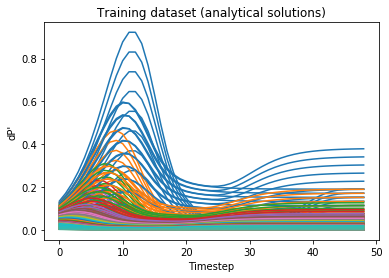

In [5]:
plt.plot(list(range(train_df.shape[0])), train_df.values)
plt.title("Training dataset (analytical solutions)")
plt.xlabel("Timestep")
plt.ylabel("dP'")
plt.show()

In [6]:
train_labels = pd.read_csv(TRAIN_LABELS, header=0)
train_labels.shape

(600, 2)

In [7]:
train_labels.groupby("class").count()

,scenario_id
class,
FAULT,200
FRACTURE,200
HOMOGENEOUS,200


In [8]:
train_labels.index = train_labels.scenario_id.astype(np.int)
train_labels = train_labels.drop(columns=['scenario_id'])

The numerical and analytical **fracture** scenarios have different model and governing equations, thus we choose half of the analytical models randomly to add to the test set.

In [9]:
fracture_idx = train_labels[train_labels == "FRACTURE"].dropna().index
frac_test_idx = np.random.choice(fracture_idx, len(fracture_idx) // 2, replace=False)
frac_test_idx

array([238, 393, 311, 203, 307, 400, 299, 399, 228, 277, 340, 389, 364,
       360, 308, 378, 275, 226, 247, 215, 321, 229, 318, 219, 273, 213,
       374, 306, 330, 221, 355, 202, 328, 350, 239, 222, 289, 331, 392,
       251, 309, 204, 291, 326, 346, 336, 345, 256, 372, 390, 323, 208,
       329, 210, 233, 366, 248, 214, 241, 380, 253, 386, 313, 314, 211,
       271, 267, 212, 395, 301, 224, 324, 220, 237, 348, 361, 339, 298,
       382, 312, 281, 285, 227, 288, 354, 293, 234, 381, 252, 295, 335,
       235, 379, 230, 304, 365, 334, 262, 287, 206])

In [10]:
test_df_fracture = train_df[frac_test_idx]
test_df_fracture.head()

,238,393,311,203,307,400,299,399,228,277,...,335,235,379,230,304,365,334,262,287,206
0,0.010261,0.066394,0.044354,0.011764,0.055482,0.046457,0.024404,0.048809,0.017465,0.021584,...,0.041849,0.011957,0.043928,0.015617,0.066316,0.093612,0.044088,0.050196,0.046235,0.009802
1,0.010250,0.070504,0.048362,0.014457,0.064023,0.045369,0.024100,0.048201,0.019860,0.021813,...,0.043330,0.012380,0.043380,0.017262,0.080164,0.111372,0.046223,0.062755,0.053353,0.011482
2,0.009656,0.071338,0.050512,0.017505,0.071666,0.041660,0.022410,0.044820,0.021832,0.020827,...,0.042550,0.012157,0.040338,0.018331,0.095075,0.129482,0.046065,0.077645,0.059722,0.013095
3,0.008522,0.068204,0.050115,0.020803,0.077278,0.035784,0.019506,0.039011,0.023029,0.018651,...,0.039316,0.011233,0.035110,0.018548,0.110105,0.146286,0.043281,0.094817,0.064399,0.014447
4,0.007032,0.061172,0.046847,0.024152,0.079640,0.028774,0.015881,0.031761,0.023117,0.015615,...,0.033992,0.009712,0.028585,0.017733,0.123795,0.159538,0.038091,0.113893,0.066367,0.015305


In [11]:
test_labels_fracture = train_labels.loc[frac_test_idx]
test_labels_fracture.head()

,class
scenario_id,
238,FRACTURE
393,FRACTURE
311,FRACTURE
203,FRACTURE
307,FRACTURE


In [12]:
train_df = train_df.drop(columns=frac_test_idx)
train_df.shape

(49, 500)

In [13]:
train_labels = train_labels.drop(index=frac_test_idx)
train_labels.shape

(500, 1)

## Plotting the dataset colored by class

In [14]:
CLASS_COLORS = {
    "FAULT": "r",
    "FRACTURE": "g",
    "HOMOGENEOUS": "b",
}

In [15]:
def plot_by_class(data, labels, data_name=""):
    fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(7, 14))

    for s in data:
        color = CLASS_COLORS[labels['class'][s]]
        ax = ax3
        if color == 'r':
            ax = ax1
        elif color == 'g':
            ax = ax2

        ax.plot(list(range(data.shape[0])), data[s], c=color)

    ax2.set_ylabel("dP'")
    ax3.set_xlabel("Timestep")

    line_legend_elements = [Line2D([0], [0], color=CLASS_COLORS['FAULT'], label='FAULT'),
                            Line2D([0], [0], color=CLASS_COLORS['FRACTURE'], label='FRACTURE'),
                            Line2D([0], [0], color=CLASS_COLORS['HOMOGENEOUS'], label='HOMOGENEOUS')]

    ax3.legend(handles=line_legend_elements)
    ax1.set_title(f'Pressure derivative - {data_name}\nClass = FAULT')
    ax2.set_title('Class = FRACTURE')
    ax3.set_title('Class = HOMOGENEOUS')
    return fig, [ax1, ax2, ax3]

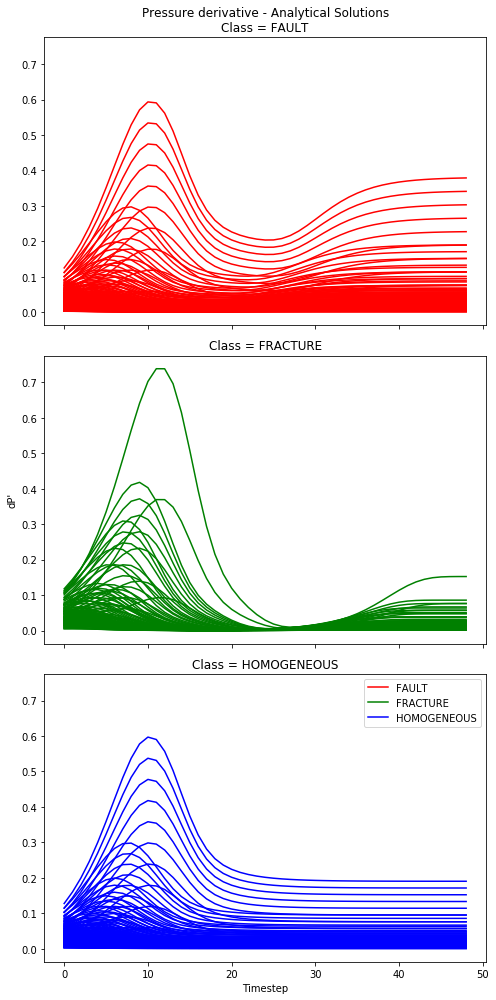

In [16]:
plot_by_class(train_df, labels=train_labels, data_name="Analytical Solutions")
plt.tight_layout()
plt.savefig(f"{FIG_FOLDER}/training_data_by_class_cd_s.pdf", bbox_inches="tight")

## Data distribution inspection

In [17]:
from sklearn.manifold import MDS

In [18]:
def plot_mds(data, labels, title=""):
    if not title:
        title = "MDS projection of the data"

    coords = MDS(n_components=2).fit_transform(data)
    fig, ax = plt.subplots(figsize=(8, 8))

    for i, p in enumerate(coords):
        ax.scatter(p[0], p[1], c=CLASS_COLORS[labels["class"].iloc[i]])

    ax.set_title(title, fontweight="bold")

    scatter_legend_elements = [Line2D([0], [0], marker='o', color='w', label='FAULT',
                                      markerfacecolor=CLASS_COLORS['FAULT'], markersize=8),
                               Line2D([0], [0], marker='o', color='w', label='FRACTURE',
                                      markerfacecolor=CLASS_COLORS['FRACTURE'], markersize=8),
                               Line2D([0], [0], marker='o', color='w', label='HOMOGENEOUS',
                                      markerfacecolor=CLASS_COLORS['HOMOGENEOUS'], markersize=8)]
    ax.legend(handles=scatter_legend_elements)
    return ax

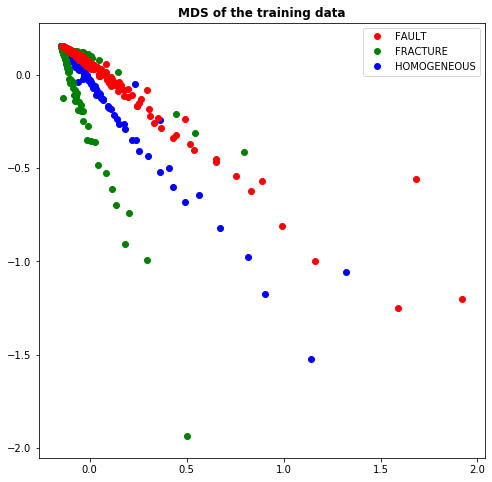

In [19]:
plot_mds(train_df.T, labels=train_labels, title="MDS of the training data")
plt.savefig(f"{FIG_FOLDER}/mds_training_data_cd_s.pdf", bbox_inches="tight")
plt.show()

## Normalization and Scaling of the training data

### Standard scaling

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
X_scaled = StandardScaler().fit_transform(train_df.values.T)
X_scaled.shape

(500, 49)

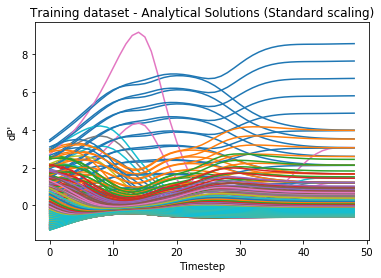

In [22]:
plt.plot(X_scaled.T)
plt.title("Training dataset - Analytical Solutions (Standard scaling)")
plt.xlabel("Timestep")
plt.ylabel("dP'")
plt.show()

In [23]:
X_scaled_df = pd.DataFrame(data=X_scaled.T, columns=train_df.columns)

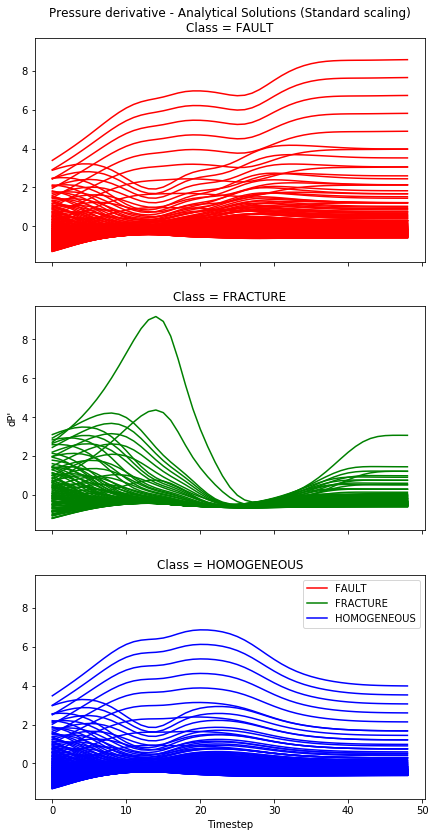

In [24]:
plot_by_class(X_scaled_df, train_labels, data_name="Analytical Solutions (Standard scaling)")
plt.savefig(f"{FIG_FOLDER}/std_centering_training_by_class_cd_s.pdf", bbox_inches="tight")
plt.show()

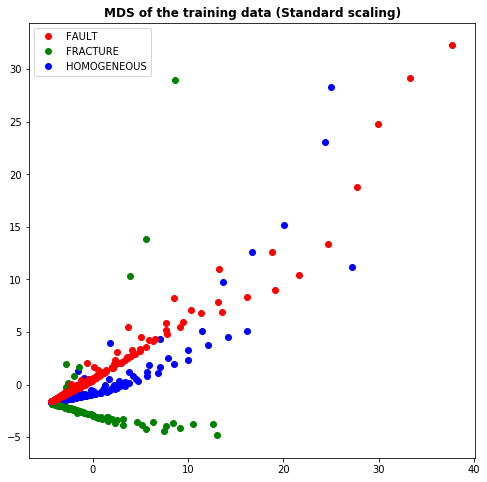

In [25]:
plot_mds(X_scaled, labels=train_labels, title="MDS of the training data (Standard scaling)")
plt.savefig(f"{FIG_FOLDER}/mds_std_centering_training_cd_s.pdf", bbox_inches="tight")
plt.show()

### Normalizing the curves

In [26]:
from sklearn.preprocessing import Normalizer

In [27]:
X_norm = Normalizer().fit_transform(train_df.values.T)
X_norm.shape

(500, 49)

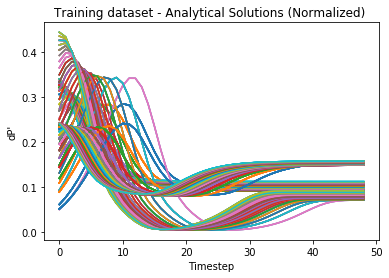

In [28]:
plt.plot(X_norm.T)
plt.title("Training dataset - Analytical Solutions (Normalized) ")
plt.xlabel("Timestep")
plt.ylabel("dP'")
plt.show()

In [29]:
X_norm_df = pd.DataFrame(data=X_norm.T, columns=train_df.columns)

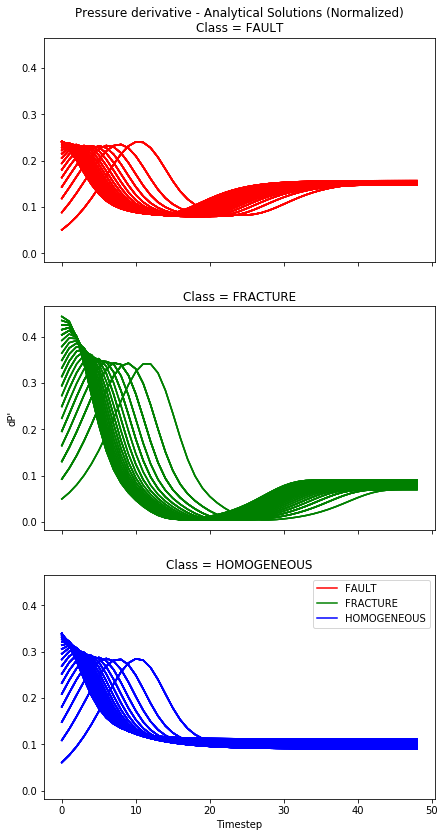

In [30]:
plot_by_class(X_norm_df, train_labels, data_name="Analytical Solutions (Normalized)")
plt.savefig(f"{FIG_FOLDER}/normalized_training_by_class_cd_s.pdf", bbox_inches="tight")
plt.show()

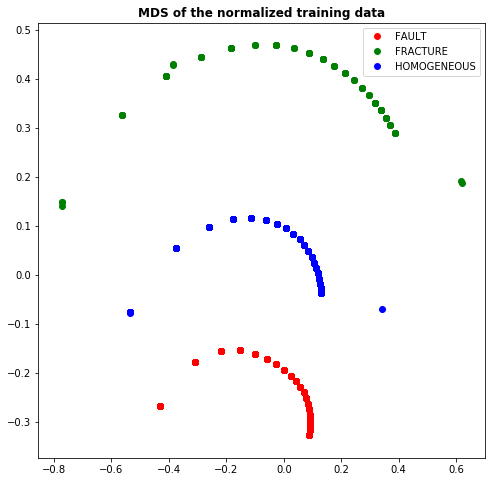

In [31]:
plot_mds(X_norm.astype(np.float16), labels=train_labels, title="MDS of the normalized training data")
plt.show()

## Calculating the shapelets for the training data

Now, we calculate the shapelets for both the scaled and normalized data

In [32]:
from classifier.shapelets import extract_shapelets, subsequence_dist

In [33]:
def calc_shapelets(data, labels, verbose=False):
    """Calculates the shapelets for a given dataset.

    Parameters
    ----------
    data : pandas.DataFrame
    labels : pandas.DataFrame
    """
    data_class = [None] * data.shape[1]
    for i, val in enumerate(data.values.T):
        data_class[i] = (val, labels.values[i])

    return extract_shapelets(data_class, min_len=5, max_len=25, verbose=verbose)

Shapelets calculation may take a very long time and, its use may not be as advantageous as indicated. Thus, we select a fraction of the dataset to obtain the shapelets.

In [34]:
PERC_ELEMENTS = 0.1
chosen_idx = {}

for label in train_labels["class"].unique():
    idx = train_labels[train_labels == label].dropna().index
    chosen_idx[label] = np.random.choice(idx, np.int(PERC_ELEMENTS * len(idx)), replace=False)

In [35]:
train_shapelet = []
train_labels_shapelet = []

for label, idx in chosen_idx.items():
    if not len(train_shapelet):
        train_shapelet = X_scaled_df[idx]
        train_labels_shapelet = train_labels.loc[idx]
    else:
        train_shapelet = pd.concat([train_shapelet, X_scaled_df[idx]], axis=1)
        train_labels_shapelet = pd.concat([train_labels_shapelet, train_labels.loc[idx]])

train_shapelet.shape

(49, 50)

In [36]:
if not os.path.exists("shapelet_synth_sample_scaled_cd_s.pickle"):
    shapelets_train_scaled = calc_shapelets(train_shapelet, train_labels_shapelet)
    fname = "shapelet_synth_sample_scaled_cd_s.pickle"
    with open(os.path.join(".", fname), "wb") as fout:
        pickle.dump(shapelets_train_scaled, fout)
else:
    with open("shapelet_synth_sample_scaled_cd_s.pickle", "rb") as fin: 
        shapelets_train_scaled = pickle.load(fin)

In [37]:
train_shapelet = []
train_labels_shapelet = []

for label, idx in chosen_idx.items():
    if not len(train_shapelet):
        train_shapelet = X_norm_df[idx]
        train_labels_shapelet = train_labels.loc[idx]
    else:
        train_shapelet = pd.concat([train_shapelet, X_norm_df[idx]], axis=1)
        train_labels_shapelet = pd.concat([train_labels_shapelet, train_labels.loc[idx]])

train_shapelet.shape

(49, 50)

In [38]:
if not os.path.exists("shapelet_synth_sample_norm_cd_s.pickle"):
    shapelets_train_norm = calc_shapelets(train_shapelet, train_labels_shapelet)
    fname = "shapelet_synth_sample_norm_cd_s.pickle"
    with open(os.path.join(".", fname), "wb") as fout:
        pickle.dump(shapelets_train_norm, fout)
else:
    with open("shapelet_synth_sample_norm_cd_s.pickle", "rb") as fin: 
        shapelets_train_norm = pickle.load(fin)

## Training the classification models

In [39]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [40]:
from classifier.voting import GSVotingClassifier

In [41]:
clf_names = ["knn", "decision_tree", "linear_svc", "perceptron", "random_forest","adaboost", "mlperceptron"]
clf_instances = [KNeighborsClassifier(), DecisionTreeClassifier(), LinearSVC(), Perceptron(), RandomForestClassifier(), AdaBoostClassifier(), MLPClassifier()]
clf_params = [
    {
        'n_neighbors': np.arange(4, 31),
    },
    {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'random_state': [42],
        'min_samples_leaf': np.arange(2, 31),
    },
    {
        'penalty': ['l1', 'l2'],
        'dual': [True, False],
        'C': np.arange(1, 10),
        'random_state': [42],
        'max_iter': [10000],
        'multi_class': ['ovr', 'crammer_singer'],
    },
    {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'max_iter': [10000],
        'early_stopping': [True],
    },
    {
        'criterion': ['gini', 'entropy'],
        'random_state': [42],
        'min_samples_leaf': np.arange(2, 31),
        'n_estimators': np.arange(10, 200, 10),
    },
    {
        'random_state': [42],
    },
    {
        'random_state': [42],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'adam'],
        'early_stopping': [True],
        'validation_fraction': [0.2],
        'hidden_layer_sizes': [(100), (100, 100), (100, 100, 100)]
    }
]

In [42]:
clf = {}
clf["scaled"] = GSVotingClassifier(estimators=zip(clf_names, clf_instances, clf_params),
                                   voting_type="hard", cv=10, top_n=5)
clf["scaled_shapelet"] = GSVotingClassifier(estimators=zip(clf_names, clf_instances, clf_params),
                                            voting_type="hard", cv=10, top_n=5)
clf["norm"] = GSVotingClassifier(estimators=zip(clf_names, clf_instances, clf_params),
                                 voting_type="hard", cv=10, top_n=5)
clf["norm_shapelet"] = GSVotingClassifier(estimators=zip(clf_names, clf_instances, clf_params),
                                          voting_type="hard", cv=10, top_n=5)

In [43]:
X = {}
X["scaled"] = X_scaled
X["norm"] = X_norm

In [44]:
def calc_shapelets_dataset(data, shapelets):
    full_dist = []
    for d in data:
        dists = []
        for val in shapelets.values():
            dist, _ = subsequence_dist(list(d), val)
            dists.append(dist)
        full_dist.append(dists)
    return np.array(full_dist)

In [45]:
X["scaled_shapelet"] = calc_shapelets_dataset(X_scaled, shapelets_train_scaled)
X["norm_shapelet"] = calc_shapelets_dataset(X_norm, shapelets_train_norm)

In [46]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for k, c in clf.items():
        c.fit(X[k], train_labels.values.ravel())

In [47]:
for k, v in clf.items():
    print(k)
    for e in v.estimators_:
        print(e)

scaled
('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform'))
('linear_svc', LinearSVC(C=5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0))
('perceptron', Perceptron(alpha=0.0001, class_weight=None, early_stopping=True, eta0=1.0,
           fit_intercept=True, max_iter=10000, n_iter_no_change=5, n_jobs=None,
           penalty='l1', random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False))
('random_forest', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                  

## Loading and inspecting the test data

In [48]:
test_df = pd.read_csv(TEST_PATH, index_col=0, header=0)
test_df.columns = test_df.columns.astype(np.int)
test_df.shape

(51, 384)

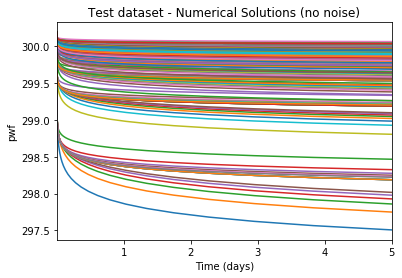

In [49]:
ax = test_df.plot(legend=False)
ax.set_title("Test dataset - Numerical Solutions (no noise)")
ax.set_xlabel("Time (days)")
ax.set_ylabel("pwf")
plt.show()

Reading the test data labels

In [50]:
test_labels = pd.read_csv(TEST_LABELS, header=0)
test_labels.shape

(384, 2)

In [51]:
test_labels.groupby("class").count()

,scenario_id
class,
FAULT,128
FRACTURE,128
HOMOGENEOUS,128


In [52]:
test_labels.index = test_labels.scenario_id.astype(np.int)
test_labels = test_labels.drop(columns=['scenario_id'])

Now, we discard the scenarios with **fracture** class from the test dataset and merge the analytical fracture model scenarios held out fom training into the test data frame

In [53]:
fracture_idx = test_labels[test_labels == "FRACTURE"].dropna().index
fracture_idx

Int64Index([ 13,  14,  15,  16,  17,  18,  35,  36,  37,  38,
            ...
            375, 376, 377, 378, 379, 380, 381, 382, 383, 384],
           dtype='int64', name='scenario_id', length=128)

In [54]:
test_df = test_df.drop(columns=fracture_idx)
test_df.shape

(51, 256)

In [55]:
test_labels = test_labels.drop(index=fracture_idx)
test_labels.shape

(256, 1)

Now, we will sort the data frame and labels by their indices and relabel them. This is because the **fracture** scenarios removed left several "holes" in the test data index. Also, the indices of analytical **fracture** scenarios witheld from training clash with indices of the remaining test scenarios.

In [56]:
test_df.sort_index(inplace=True, axis=1)
test_df.columns = range(1, test_df.shape[1] + 1)
test_labels.sort_index(inplace=True, axis=0)
test_labels.index = range(1, test_df.shape[1] + 1)

Before the merge, we must calculate the pressure derivative.

In [57]:
from sim import calc_log_derivative

In [58]:
test_df = 300 - test_df
test_df = test_df.apply(calc_log_derivative)
test_df.shape

(49, 256)

In [59]:
test_df_fracture.sort_index(inplace=True, axis=1)
test_df_fracture.columns = range(test_df.shape[1] + 1, test_df.shape[1] + test_df_fracture.shape[1] + 1)
test_labels_fracture.sort_index(inplace=True, axis=0)
test_labels_fracture.index = range(test_df.shape[1] + 1, test_df.shape[1] + test_df_fracture.shape[1] + 1)

In [60]:
test_labels = pd.concat([test_labels, test_labels_fracture])

In [61]:
test_df = pd.concat([test_df.reset_index(drop=True), test_df_fracture], axis=1)
test_df.shape

(49, 356)

Text(0, 0.5, "dP'")

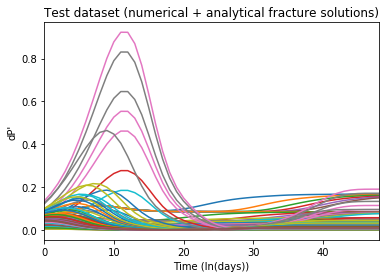

In [62]:
ax = test_df.plot(legend=False)
ax.set_title("Test dataset (numerical + analytical fracture solutions)")
ax.set_xlabel("Time (ln(days))")
ax.set_ylabel("dP'")

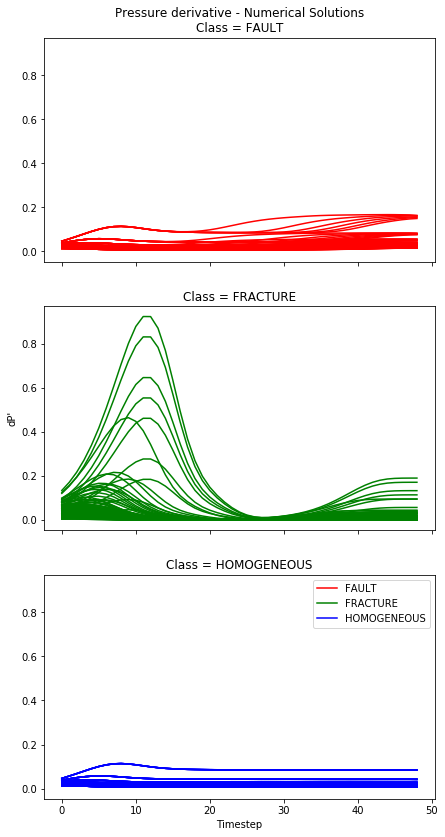

In [63]:
plot_by_class(test_df, test_labels, data_name="Numerical Solutions")
plt.savefig(f"{FIG_FOLDER}/test_data_by_class.pdf", bbox_inches="tight")
plt.show()

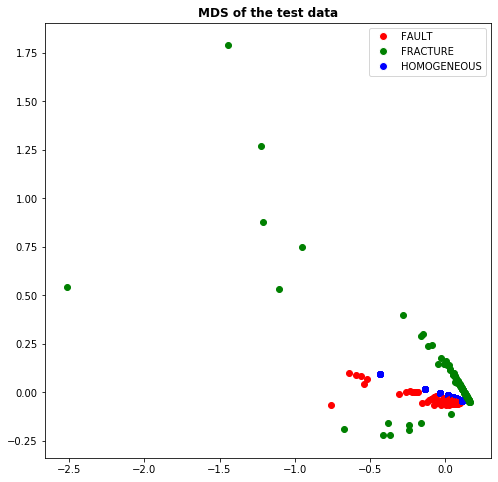

In [64]:
plot_mds(test_df.T, labels=test_labels, title="MDS of the test data")
plt.savefig(f"{FIG_FOLDER}/mds_test_data.pdf", bbox_inches="tight")
plt.show()

### Standard scaling

In [65]:
X_scaled_test = StandardScaler().fit_transform(test_df.values.T)
X_scaled_test.shape

(356, 49)

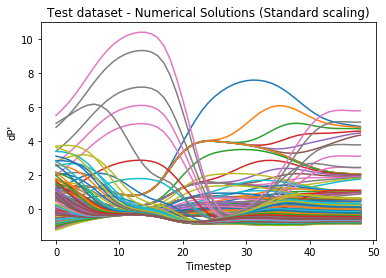

In [66]:
plt.plot(X_scaled_test.T)
plt.title("Test dataset - Numerical Solutions (Standard scaling)")
plt.xlabel("Timestep")
plt.ylabel("dP'")
plt.show()

In [67]:
X_scaled_test_df = pd.DataFrame(data=X_scaled_test.T, columns=test_df.columns)

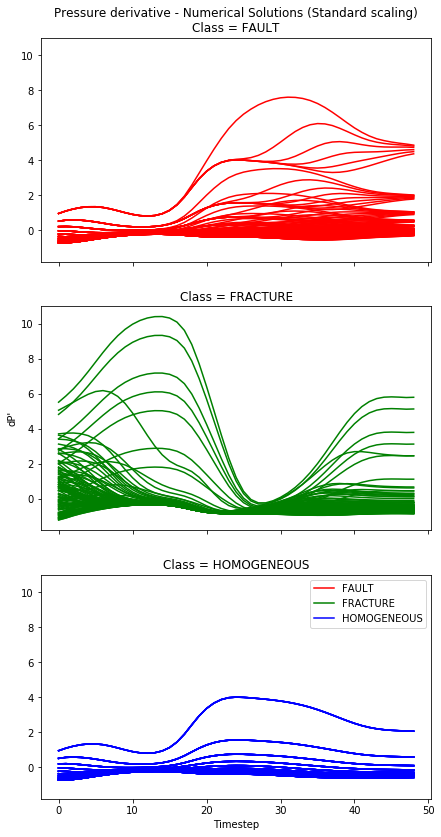

In [68]:
plot_by_class(X_scaled_test_df, test_labels, data_name="Numerical Solutions (Standard scaling)")
plt.savefig(f"{FIG_FOLDER}/std_centering_test_by_class.pdf", bbox_inches="tight")
plt.show()

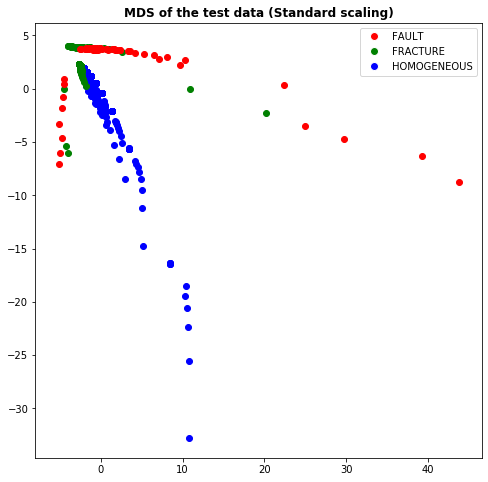

In [69]:
plot_mds(X_scaled_test, labels=train_labels, title="MDS of the test data (Standard scaling)")
plt.savefig(f"{FIG_FOLDER}/mds_std_centering_test.pdf", bbox_inches="tight")
plt.show()

### Normalizing the test data to norm 1

In [70]:
X_norm_test = Normalizer().fit_transform(test_df.values.T)
X_norm_test.shape

(356, 49)

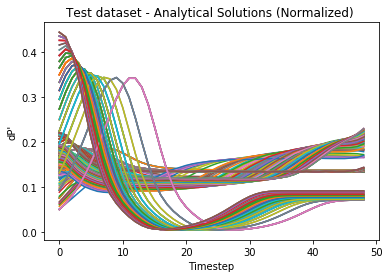

In [71]:
plt.plot(X_norm_test.T)
plt.title("Test dataset - Analytical Solutions (Normalized) ")
plt.xlabel("Timestep")
plt.ylabel("dP'")
plt.show()

In [72]:
X_norm_test_df = pd.DataFrame(data=X_norm_test.T, columns=test_df.columns)

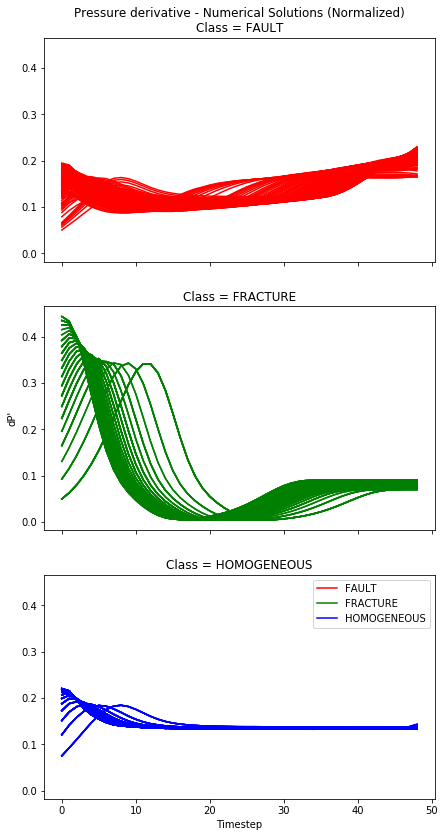

In [73]:
plot_by_class(X_norm_test_df, test_labels, data_name="Numerical Solutions (Normalized)")
plt.savefig(f"{FIG_FOLDER}/normalized_test_by_class.pdf", bbox_inches="tight")
plt.show()

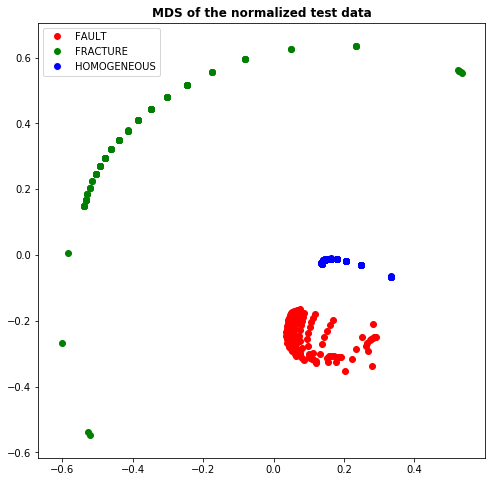

In [74]:
plot_mds(X_norm_test.astype(np.float32), labels=test_labels, title="MDS of the normalized test data")
plt.savefig(f"{FIG_FOLDER}/mds_normalized_test.pdf", bbox_inches="tight")
plt.show()

## Finally the actual prediction and classification metrics calculation

First, we process the shapelets versions of the dataset and insert them in a dict.

In [75]:
X_test = {}
X_test["scaled"] = X_scaled_test
X_test["norm"] = X_norm_test

In [76]:
X_test["scaled_shapelet"] = calc_shapelets_dataset(X_scaled_test, shapelets_train_scaled)
X_test["norm_shapelet"] = calc_shapelets_dataset(X_norm_test, shapelets_train_norm)

Now, we run the prediction itself.

In [77]:
yhat = {}
for k, v in clf.items():
    yhat[k] = v.predict(X_test[k])

Now, we calculate the classification metrics

In [78]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

In [79]:
le = clf["scaled"].le_
ytrue = test_labels.values.ravel()

In [80]:
for k, v in yhat.items():
    print(k.upper())
    print(precision_recall_fscore_support(ytrue, v, labels=le.classes_, beta=1, average="macro"))
    print(classification_report(ytrue, v, labels=le.classes_))
    print("---------------------------------------------------------")

SCALED
(0.9024809629083763, 0.9010416666666666, 0.9008904374758034, None)
              precision    recall  f1-score   support

       FAULT       0.83      0.89      0.86       128
    FRACTURE       1.00      1.00      1.00       100
 HOMOGENEOUS       0.88      0.81      0.85       128

    accuracy                           0.89       356
   macro avg       0.90      0.90      0.90       356
weighted avg       0.89      0.89      0.89       356

---------------------------------------------------------
SCALED_SHAPELET
(0.5280900032144006, 0.5667708333333333, 0.5180556426933238, None)
              precision    recall  f1-score   support

       FAULT       0.62      0.61      0.62       128
    FRACTURE       0.52      0.88      0.65       100
 HOMOGENEOUS       0.44      0.21      0.29       128

    accuracy                           0.54       356
   macro avg       0.53      0.57      0.52       356
weighted avg       0.53      0.54      0.51       356

-----------------------

/home/gschardong/projects/interference-tests/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finally, let's plot the mismatched curves by class.

## Plotting the mismatched curves

In [81]:
data_name_prettyname = {
    "scaled": "Scaled",
    "norm": "Normalized",
    "scaled_shapelet": "Scaled (Shapelets)",
    "norm_shapelet": "Normalized (Shapelets)",
}

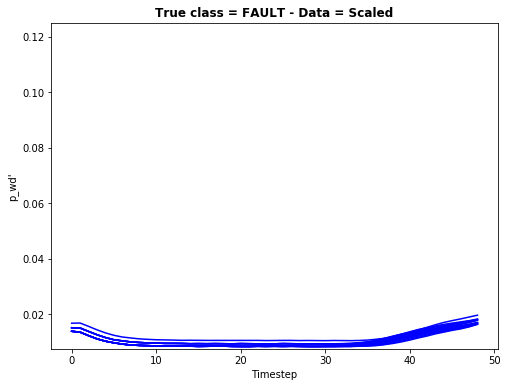

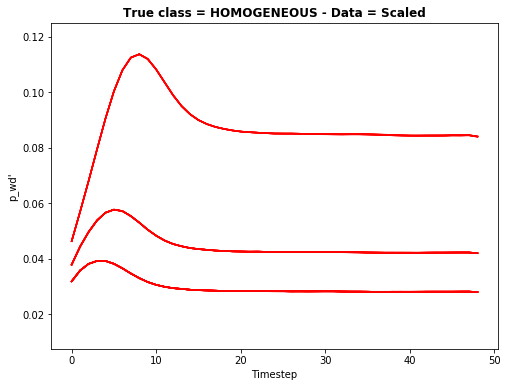

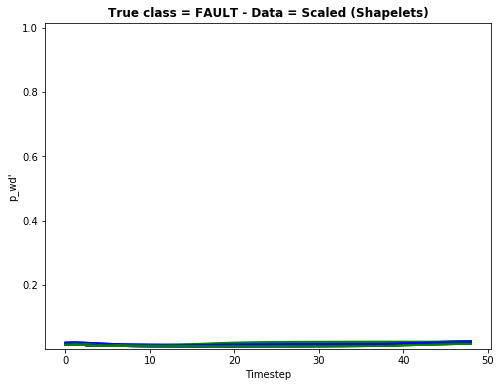

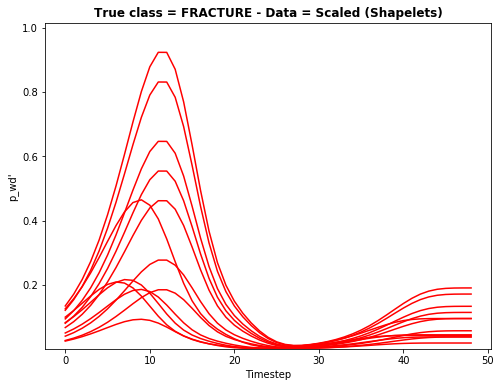

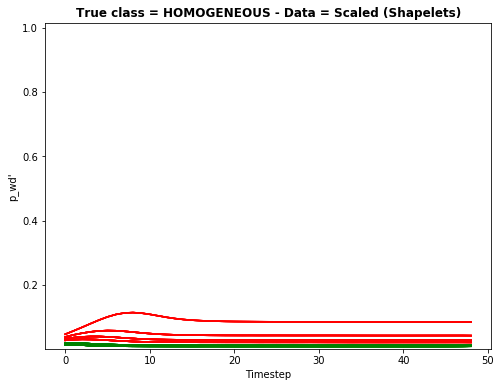

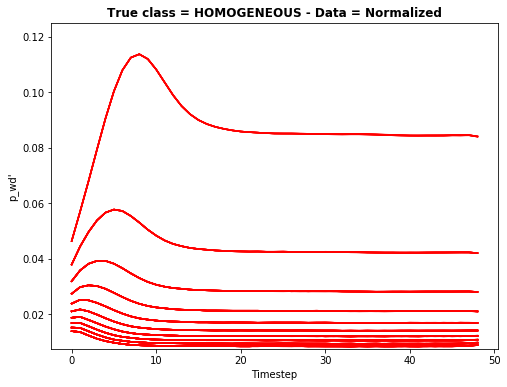

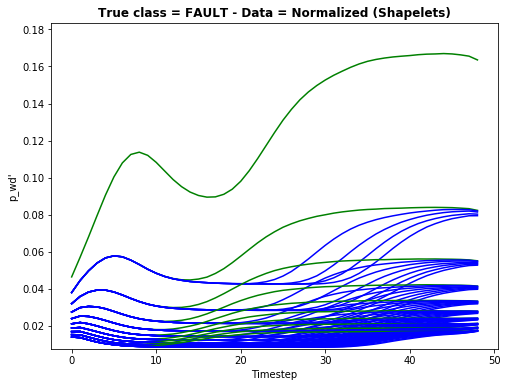

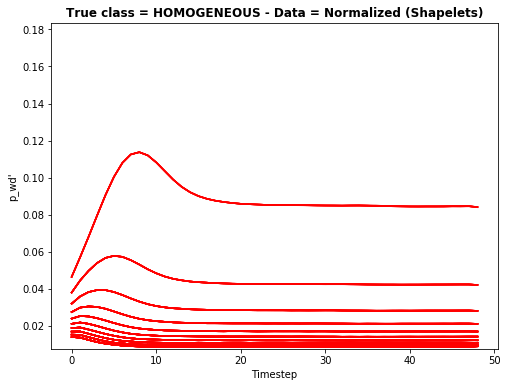

In [82]:
for k in yhat.keys():
    mismatched_idx = np.argwhere(ytrue != yhat[k]).ravel()

    if not any(mismatched_idx):
        continue
    
    ylims = (0.9 * test_df[mismatched_idx + 1].min().min(), 1.1 * test_df[mismatched_idx + 1].max().max())

    for c in le.classes_:
        mismatched_idx_class = ytrue[mismatched_idx] == c
        if not any(mismatched_idx_class):
            continue
        
        mismatched_idx_class = mismatched_idx[mismatched_idx_class]
        mismatched_series = X_test[k][mismatched_idx_class, :]
        mismatched_series = test_df[mismatched_idx_class + 1]

        fig, ax = plt.subplots(1, figsize=(8, 6))
        ax.set_title(f"True class = {c} - Data = {data_name_prettyname[k]}", fontweight="bold")
        ax.set_ylabel("p_wd'")
        ax.set_xlabel("Timestep")
        ax.set_ylim(bottom=ylims[0], top=ylims[1])

        for i, s in enumerate(mismatched_series):
            color = CLASS_COLORS[yhat[k][mismatched_idx_class[i]]]
            ax.plot(list(range(mismatched_series.shape[0])), mismatched_series[s], c=color)

        plt.savefig(f"{FIG_FOLDER}/mismatched_{k}_{c.lower()}_cd_s.pdf", bbox_inches="tight")
        #plt.show()

## Plotting the shapelets

In [83]:
line_legend_elements = [Line2D([0], [0], color=CLASS_COLORS['FAULT'], label='FAULT'),
                            Line2D([0], [0], color=CLASS_COLORS['FRACTURE'], label='FRACTURE'),
                            Line2D([0], [0], color=CLASS_COLORS['HOMOGENEOUS'], label='HOMOGENEOUS')]

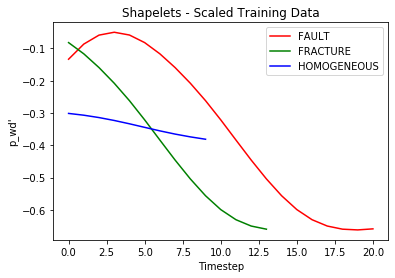

In [84]:
fig, ax = plt.subplots()
ax.set_xlabel("Timestep")
ax.set_ylabel("p_wd'")
ax.set_title("Shapelets - Scaled Training Data")
for k, v in shapelets_train_scaled.items():
    ax.plot(list(range(v.shape[0])), v, c=CLASS_COLORS[k])
ax.legend(handles=line_legend_elements)
plt.savefig(f"{FIG_FOLDER}/shapelets_synth_scaled_cd_s.pdf", bbox_inches="tight")

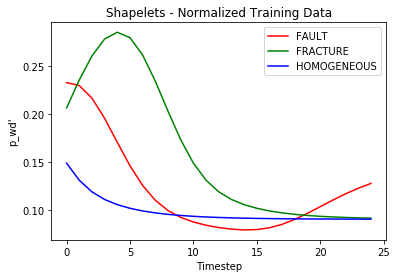

In [85]:
fig, ax = plt.subplots()
ax.set_xlabel("Timestep")
ax.set_ylabel("p_wd'")
ax.set_title("Shapelets - Normalized Training Data")
for k, v in shapelets_train_norm.items():
    ax.plot(list(range(v.shape[0])), v, c=CLASS_COLORS[k])
ax.legend(handles=line_legend_elements)
plt.savefig(f"{FIG_FOLDER}/shapelets_synth_norm_cd_s.pdf", bbox_inches="tight")

In [86]:
from sklearn.metrics import multilabel_confusion_matrix

In [87]:
cm = {}
for k, v in yhat.items():
    cm[k] = multilabel_confusion_matrix(ytrue, v, labels=["HOMOGENEOUS", "FAULT", "FRACTURE"])

In [88]:
for k, v in cm.items():
    print(k)
    print(v)

scaled
[[[214  14]
  [ 24 104]]

 [[204  24]
  [ 14 114]]

 [[256   0]
  [  0 100]]]
scaled_shapelet
[[[194  34]
  [101  27]]

 [[181  47]
  [ 50  78]]

 [[174  82]
  [ 12  88]]]
norm
[[[228   0]
  [128   0]]

 [[100 128]
  [  0 128]]

 [[256   0]
  [  0 100]]]
norm_shapelet
[[[156  72]
  [128   0]]

 [[100 128]
  [ 82  46]]

 [[246  10]
  [  0 100]]]
